In [ ]:
import torch
import torch.nn as nn

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [4]:
N = 100
T = 200
batch_size = 500

## data generation

In [5]:
def generate_data(T, N):
    Sigma = stats.invwishart.rvs(df=2*(N+1), scale=np.eye(N))*(2*(N+1)-N-1)
    R = np.random.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T).T
    return Sigma, R

In [148]:
def generate_financial_covariance(T,N, n_factors=5, market_strength=0.7, sector_strength=0.25, noise_strength=0.1):
    # Market factor (common to all assets) — how each asset react to the market
    market_loadings = np.random.uniform(0.5, 1.0, size=(N, 1))
    Sigma_market = market_strength * (market_loadings @ market_loadings.T)
    # market strength :control how dominant the market effect is

    # sector factors (clustered correlations)
    n_sectors = n_factors - 1 # one market + n_sectors sectors
    sector_size = N // n_sectors
    Sigma_sectors = np.zeros((N, N))
    for s in range(n_sectors):
        idx = slice(s * sector_size, (s + 1) * sector_size)
        A = np.random.randn(sector_size, sector_size) # random factor matrix (like for market but localy here)
        Sigma_sectors[idx, idx] = sector_strength * (A @ A.T) / sector_size # assets in the same sector have additional correlations beyond the market

    # Idiosyncratic noise (diagonal)
    diag_noise = noise_strength * np.random.uniform(0.5, 1.5, N)
    Sigma_diag = np.diag(diag_noise) # unique risk per asset, unsure that the matrix is full-rank also

    # Combine all components
    Sigma = Sigma_market + Sigma_sectors + Sigma_diag

    # Normalize trace - > tend to a trace = N, nice for later when we compare cleaned vs noisy vs true cov matrix
    Sigma *= N / np.trace(Sigma)

    R = np.random.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T).T # log return are normally distributed

    return Sigma,R


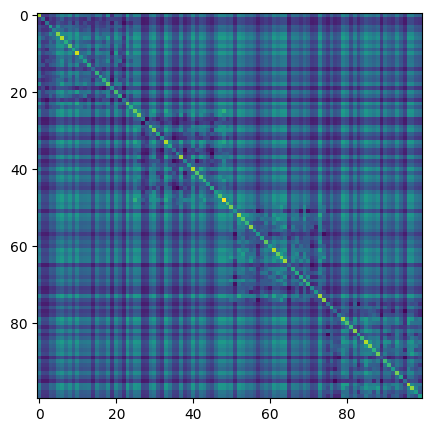

In [146]:
Sigma,R = generate_financial_covariance(T,N)
plt.figure(figsize=(6,5))
plt.imshow(Sigma, cmap='viridis')
plt.show()

In [8]:
def make_monotone_pattern(R):
    n, T = R.shape

    t = np.concatenate([np.random.default_rng().integers(low=T//2.5, high=T+1, size=n-1), [T]])
    t_vec = T - np.sort(t)[::-1]

    cols = np.arange(T)[None, :]

    mask = cols >= t_vec[:, None]

    R_mono = R.copy().astype(float)
    R_mono[~mask] = -5.0

    return R_mono, t_vec, mask


In [9]:
def fit_monotone_regressions(R, t_vec):
    n, T = R.shape
    phi_list = []
    for k in range(n):
        t_k = t_vec[k]
        y = R[k,t_k:]
        if k==0:
            beta0 = np.nanmean(R[0, :])
            beta = np.array([])
            resid = y - beta0
            sigma2 = float(resid.T @ resid) / len(resid)
            phi_list.append((beta0, beta, sigma2))
        else:
            X = R[:k,t_k:].T
            reg = LinearRegression(fit_intercept=True)
            reg.fit(X, y)

            beta0 = reg.intercept_
            beta = reg.coef_
            resid = y -reg.predict(X)

            sigma2 = (resid.T @ resid) / len(resid) 
            phi_list.append((beta0, beta, sigma2))
    return phi_list

In [10]:
import numpy as np

def reconstruct_mu_sigma_from_phi(phi_list):

    p = len(phi_list)
    mu = np.zeros(p, dtype=float)
    Sigma = np.zeros((p, p), dtype=float)

    beta0_1, beta_1, sigma2_1 = phi_list[0]
    mu[0] = beta0_1
    Sigma[0, 0] = sigma2_1 

    for k in range(1, p):
        beta0_k, beta_k, sigma2_k = phi_list[k]

        mu[k] = beta0_k + beta_k @ mu[:k]

        S11 = Sigma[:k, :k]

        cross = beta_k @ S11
        Sigma[k, :k] = cross
        Sigma[:k, k] = cross.T

        Sigma[k, k] = sigma2_k + cross @ beta_k.T

    return mu, Sigma


## Global function for data generation

In [13]:
def generate_batch(N, T, batch_size, function):
    Sigma_hat_batch = []
    sigma_batch = []
    for _ in range(batch_size):
        Sigma, R = function(T, N)
        R_hat, t_vec, _ = make_monotone_pattern(R)
        
        _, Sigma_hat = reconstruct_mu_sigma_from_phi(fit_monotone_regressions(R_hat, t_vec))
        Sigma_hat_batch.append(Sigma_hat)
        sigma_batch.append(Sigma)

    return np.array(Sigma_hat_batch), np.array(sigma_batch)

In [14]:
sigma_hat_batch, sigma_batch = generate_batch(N, T, batch_size, generate_financial_covariance)

In [24]:
#train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])


## data formating for NN

In [15]:
def eigen_decomp(Sigmas):
    eigvals, eigvecs = [], []
    for Sigma in Sigmas:
        vals, vecs = np.linalg.eig(Sigma)
        # sort desending
        idx = np.unravel_index(np.argsort(vals)[::-1], vals.shape)
        eigvals.append(vals[idx])
        eigvecs.append(vecs[idx])
    return eigvals, eigvecs

In [16]:
eigvals_hat_batch, eigvecs_hat_batch = eigen_decomp(sigma_hat_batch)
eigvals_batch, eigvecs_batch = eigen_decomp(sigma_batch)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu" # my computer has no cuda (not NVidia GPU)

we don't take in account the mask now, but it could be done later on

In [ ]:
lam_in_t = torch.tensor(eigvals_hat_batch, dtype=torch.float32, device=device).unsqueeze(-1) # (B, N, 1) 
lam_true_t = torch.tensor(eigvals_batch,     dtype=torch.float32, device=device) # (B, N)

Q_in_t = torch.tensor(eigvecs_hat_batch, dtype=torch.float32, device=device) # to reconstruct Sigma_clean

Sigma_noisy = torch.tensor(np.array(sigma_hat_batch), dtype=torch.float32, device=device) # to compare with true Sigma and compare the differences
Sigma_true_t = torch.tensor(np.array(sigma_batch), dtype=torch.float32, device=device) # to compare with reconstructed Sigma

/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_63872/1713738478.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  lam_in_t   = torch.tensor(eigvals_hat_batch, dtype=torch.float32, device=device).unsqueeze(-1) # (Batch_size, N, 1)
/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_63872/1713738478.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  Q_in_t     = torch.tensor(eigvecs_hat_batch, dtype=torch.float32, device=device) # to reconstruct Sigma


$$\hat{\Sigma} = \hat{Q} \hat{\Lambda} \hat{Q}^T$$

$$\tilde{\Sigma}_{NN} = \hat{Q} \tilde{\Lambda}_{NN} \hat{Q}^T$$

## NN

In [20]:
class BiGRUSpectralDenoiser(nn.Module):
    def __init__(self, N, hidden_size): 
        # N : the number of eigenvalues per sample; 
        # hidden_size : the dimension of the GRU’s hidden state
        super().__init__()

        self.gru = nn.GRU(
            input_size=1, #The number of input features per sequence data, 1 here
            hidden_size=hidden_size, #Tumber of features in the hidden state, one still one eigenvalue
            num_layers=1, # amount of GRU we put one after-another
            bias=True, # We always want bias
            batch_first=True, #input and output tensors are provided as (batch, seq, feature)
            bidirectional=True #
            )
        self.fc = nn.Linear(2 * hidden_size * N, N) # to adapt NN's output to a vector of eigenvalues
        self.activation = nn.Softplus() # keeps positive eigenvalues

    def forward(self, x):
        h, _ = self.gru(x) # (B, N, 2H)
        h = h.reshape(h.size(0), -1) # (B, N * 2H) - flatten
        out = self.fc(h)
        out = self.activation(out)
        return out.squeeze(-1)

In [31]:
model = BiGRUSpectralDenoiser(N,hidden_size=64) # hidden_size to be tunned

In [32]:
def loss_function(lam_pred, lam_true, Q, Sigma_true, alpha, beta):
    mse = nn.MSELoss()

    # Eigenvalue-level MSE
    loss_spec = mse(lam_pred, lam_true) / lam_true.abs().mean()

    # Covariance-level MSE
    Lambda_pred = torch.diag_embed(lam_pred)
    Sigma_pred = Q @ Lambda_pred @ Q.transpose(1, 2)
    loss_cov = mse(Sigma_pred, Sigma_true) / Sigma_true.abs().mean()

    # Trace loss
    trace_pred = Sigma_pred.diagonal(dim1=1, dim2=2).sum(dim=1) # (B,)
    trace_true = Sigma_true.diagonal(dim1=1, dim2=2).sum(dim=1)
    loss_trace = mse(trace_pred, trace_true) / trace_true.abs().mean() 
    
    # Combined loss, each term is normalized
    total_loss = alpha * loss_spec + beta *  loss_cov + (1 - beta - alpha) * loss_trace
    return total_loss

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-6) # lr and weight_decay to be tuned

### Training loop

On pourra rajouter dans la loss un terme pour comparer les valeurs propres/les matrices totals par exemples des matrices.

On pourrait calculer la loss par epochs d'une tailles plus petites ou même aléatoire

In [34]:
losses = []

In [61]:
# batch are full for now

epochs = 450
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    lam_pred = model(lam_in_t)  # forward pass through GRU

    # compute losses
    loss = loss_function(lam_pred, lam_true_t, Q_in_t, Sigma_true_t, 0.33, 0.33)

    # backprop
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} — loss: {loss.item():.6f}")


Epoch 50/450 — loss: 0.082565
Epoch 100/450 — loss: 0.082417
Epoch 150/450 — loss: 0.082285
Epoch 200/450 — loss: 0.082164
Epoch 250/450 — loss: 0.152579
Epoch 300/450 — loss: 0.081993
Epoch 350/450 — loss: 0.082129
Epoch 400/450 — loss: 0.081893
Epoch 450/450 — loss: 0.081906


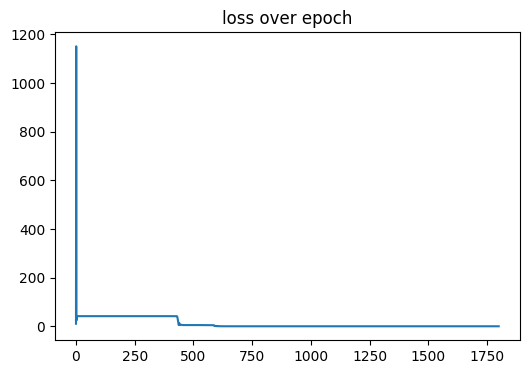

In [62]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("loss over epoch")
plt.show()

It seems there is levels, here there is 2. and our mse is small for eigenvalue as well as trace, but not that small for the matrix it self.

### in sample comparaison

In [63]:
lam_pred = model(lam_in_t)   # (B, N) predicted cleaned eigenvalues
lam_true = lam_true_t        # (B, N) true (population) eigenvalues
lam_noisy = lam_in_t.squeeze(-1)  # (B, N) noisy sample eigenvalues

Comparaison eigenvalues $\lambda$

In [64]:
mse = nn.MSELoss()
# or torch.mean((lam_noisy - lam_true)**2).item()

In [65]:
import torch

mse_noisy = mse(lam_noisy,lam_true)
mse_pred  = mse(lam_pred, lam_true)

print(f"MSE noisy  : {mse_noisy:.6f}")
print(f"MSE cleaned: {mse_pred:.6f}")


MSE noisy  : 3036.835938
MSE cleaned: 0.017729


Comparaison Trace

In [66]:
trace_true = lam_true.sum(dim=1).mean()
trace_pred = lam_pred.sum(dim=1).mean()
trace_noisy = lam_noisy.sum(dim=1).mean()

print(f"Real Trace : {trace_true:.4f}, predicted : {trace_pred:.4f}, noisy : {trace_noisy:.4f}")

Real Trace : 100.0000, predicted : 100.2957, noisy : 211.0847


1000 fois mieux

Comparaison matrix $\Sigma$

In [67]:
def reconstruct_cov(Q, lam):
    # Diagonalize λ
    Lambda = torch.diag_embed(lam)       # (B, N, N)
    Sigma = Q @ Lambda @ Q.transpose(1, 2)
    return Sigma

In [68]:
Sigma_true = Sigma_true_t
Sigma_noisy = Sigma_noisy
Sigma_gru   = reconstruct_cov(Q_in_t, lam_pred)

In [ ]:
fro_noisy = mse(Sigma_noisy, Sigma_true)
fro_gru   = mse(Sigma_gru, Sigma_true)

print(f"Frobenius error (noisy):  {fro_noisy:.6f}")
print(f"Frobenius error (GRU)  :  {fro_gru:.6f}")


Frobenius error (noisy):  31.048109
Frobenius error (GRU)  :  0.104746


300 fois mieux

In [71]:
#try with ?
def frobenius_error(A, B):
    return torch.mean(torch.norm(A - B, dim=(1, 2)))

### out of sample comparaison

In [73]:
sigma_hat_batch_oos, sigma_batch_oos = generate_batch(N, T, int(batch_size/4), generate_financial_covariance) # generate 20 % more data

In [74]:
eigvals_hat_batch_oos, eigvecs_hat_batch_oos = eigen_decomp(sigma_hat_batch_oos)
eigvals_batch_oos, eigvecs_batch_oos = eigen_decomp(sigma_batch_oos)

In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu" # my computer has no cuda (not NVidia GPU)

In [84]:
lam_in_t_oos   = torch.tensor(eigvals_hat_batch_oos, dtype=torch.float32, device=device).unsqueeze(-1) # (Batch_size, N, 1) 
lam_true_t_oos = torch.tensor(eigvals_batch_oos,     dtype=torch.float32, device=device) # (B, N)

Q_in_t_oos     = torch.tensor(eigvecs_hat_batch_oos, dtype=torch.float32, device=device) # to reconstruct Sigma

Sigma_noisy_oos = torch.tensor(np.array(sigma_hat_batch_oos), dtype=torch.float32, device=device) # to compare with reconstructed Sigma
Sigma_true_t_oos = torch.tensor(np.array(sigma_batch_oos), dtype=torch.float32, device=device) # to compare with reconstructed Sigma

/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_63872/2063753762.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  lam_in_t_oos   = torch.tensor(eigvals_hat_batch_oos, dtype=torch.float32, device=device).unsqueeze(-1) # (Batch_size, N, 1)
/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_63872/2063753762.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  Q_in_t_oos     = torch.tensor(eigvecs_hat_batch_oos, dtype=torch.float32, device=device) # to reconstruct Sigma


In [87]:
lam_pred_test = model(lam_in_t_oos)
lam_in_t_oos.size()

torch.Size([125, 100, 1])

In [90]:
lam_in_t_oos.size()

torch.Size([125, 100, 1])

Comparaison eigenvalues $\lambda$

In [114]:
import torch

mse_pred_test_lam  = mse(lam_pred_test,lam_true_t_oos)
mse_noisy_test_lam = mse(lam_in_t_oos.squeeze(-1),lam_true_t_oos)

print(f"MSE noisy  : {mse_noisy_test_lam:.6f}")
print(f"MSE cleaned: {mse_pred_test_lam:.6f}")


MSE noisy  : 227.755020
MSE cleaned: 0.017419


Comparaison Trace

In [115]:
trace_true_test = lam_true_t_oos.sum(dim=1).mean()
trace_pred_test = lam_pred_test.sum(dim=1).mean()
trace_noisy_test = lam_in_t_oos.sum(dim=1).mean()

print(f"Real Trace : {trace_true_test:.4f}, predicted : {trace_pred_test:.4f}, noisy : {trace_noisy_test:.4f}")

Real Trace : 100.0000, predicted : 100.2755, noisy : 165.8992


In [116]:
mse_tr_test_pred = mse(trace_true_test,trace_pred_test)
mse_tr_test_in = mse(trace_true_test,trace_noisy_test)

In [117]:
print(f"MSE tr noisy  : {mse_tr_test_pred:.6f}")
print(f"MSE tr cleaned: {mse_tr_test_in:.6f}")

MSE tr noisy  : 0.075890
MSE tr cleaned: 4342.702637


600 fois mieux

Comparaison matrix $\Sigma$

In [ ]:
def reconstruct_cov(Q, lam):
    Lambda = torch.diag_embed(lam)
    Sigma = Q @ Lambda @ Q.transpose(1, 2)
    return Sigma

In [119]:
Sigma_true_test = Sigma_true_t_oos
Sigma_noisy_test = Sigma_noisy_oos
Sigma_pred_test   = reconstruct_cov(Q_in_t_oos, lam_pred_test)

In [120]:
fro_noisy_test_mat = mse(Sigma_noisy_test, Sigma_true_test)
fro_pred_test_mat   = mse(Sigma_pred_test, Sigma_true_test)

print(f"mse error (noisy):  {fro_noisy_test_mat:.6f}")
print(f"mse error (GRU)  :  {fro_pred_test_mat:.6f}")


mse error (noisy):  2.576258
mse error (GRU)  :  0.088326


300 fois mieux

In [129]:
pairs = ['Matrix', 'Trace', 'EigenValues']
mse_noisy   = [fro_noisy_test_mat.item(), mse_tr_test_in.item(), mse_noisy_test_lam.item()]
mse_cleaned = [fro_pred_test_mat.item(), mse_tr_test_pred.item(), mse_pred_test_lam.item()]

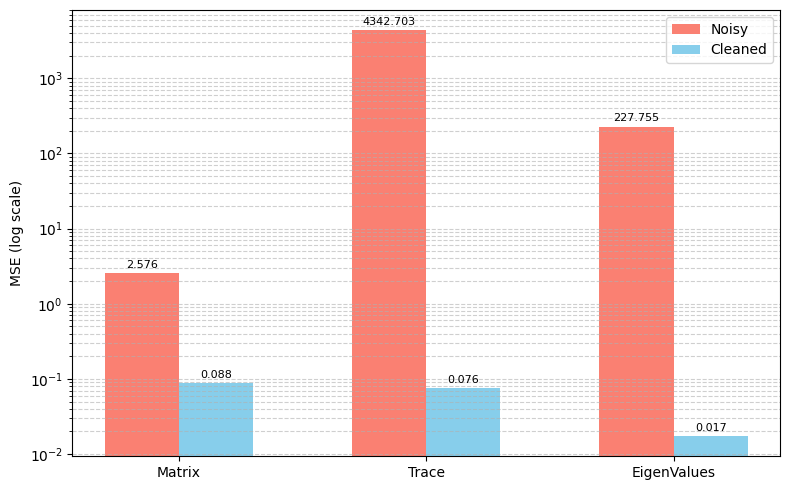

In [132]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(pairs))
width = 0.3

plt.figure(figsize=(8,5))
plt.bar(x - width/2, mse_noisy, width, label='Noisy', color='salmon')
plt.bar(x + width/2, mse_cleaned, width, label='Cleaned', color='skyblue')

plt.yscale('log')
plt.ylabel('MSE (log scale)')
plt.xticks(x, pairs)
plt.legend()
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)

for i, (n, c) in enumerate(zip(mse_noisy, mse_cleaned)):
    plt.text(x[i] - width/2, n*1.1, f"{n:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + width/2, c*1.1, f"{c:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('images/results_NN_oos')
plt.show()
